In [1]:
# Task for the 15th of December, 2017



# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../..")

import gempy as gp
%matplotlib inline

import numpy as np
import pandas as pn
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Imports of libraries needed in the following code

from mpl_toolkits.mplot3d import Axes3D
import itertools
from scipy.spatial import ConvexHull

In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'serif',
              'transition': 'slide',
              'start_slideshow_at': 'selected',
              'scroll': True,
})

{'scroll': True,
 'start_slideshow_at': 'selected',
 'theme': 'serif',
 'transition': 'slide'}

In [3]:
# Load data, define resolution 
# Note: resolution (res) and domain boundaries are defined beforehand now as variables as they are needed for 
# various causes later as well (like computing the centroids)
res = 3
xdown = -10; xup = 30; ydown = -10; yup = 20; zdown = -10; zup = 0

geo_data = gp.create_data([xdown,xup,ydown,yup,zdown,zup],[res, res, res],
                         path_f = "paper_Foliations.csv",
                         path_i = "paper_Points.csv")
geo_data.add_interface(X=10, Y=4, Z=-7, formation='fault1')

geo_data.interfaces.set_value(geo_data.interfaces['formation'] == 'Layer1', 'Z_std', 2)
geo_data.interfaces.set_value(geo_data.interfaces['formation'] == 'Layer2', 'Z_std', 2)


,X,Y,Z,formation,series,order_series,isFault,formation number,annotations,Z_std
0,4.345153,5.0,-1.921564,fault1,Default serie,1,False,1,"${\bf{x}}_{\alpha \,{\bf{1}},0}$",NaN
1,10.000000,4.0,-7.000000,fault1,Default serie,1,False,1,"${\bf{x}}_{\alpha \,{\bf{1}},1}$",NaN
2,2.303022,5.0,-1.647248,Unconformity,Default serie,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},0}$",NaN
3,1.083840,5.0,-1.738687,Unconformity,Default serie,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},1}$",NaN
4,8.825648,5.0,-3.140747,Unconformity,Default serie,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},2}$",NaN
5,15.561631,5.0,-3.232185,Unconformity,Default serie,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},3}$",NaN
6,2.211584,5.0,-5.518153,Layer1,Default serie,1,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},0}$",2.0
7,11.172574,5.0,-6.981171,Layer1,Default serie,1,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},1}$",2.0
8,15.104438,5.0,-8.108915,Layer1,Default serie,1,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},2}$",2.0
9,2.059186,5.0,-4.908561,Layer2,Default serie,1,False,4,"${\bf{x}}_{\alpha \,{\bf{4}},0}$",2.0


In [4]:
gp.get_surfaces(geo_data)

([], [])

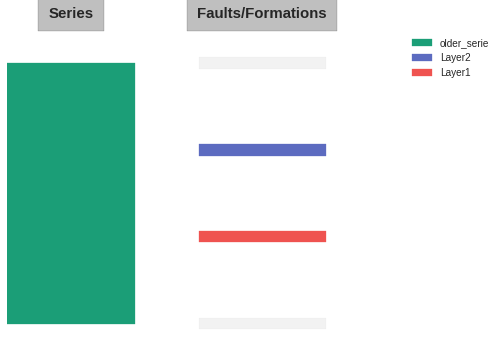

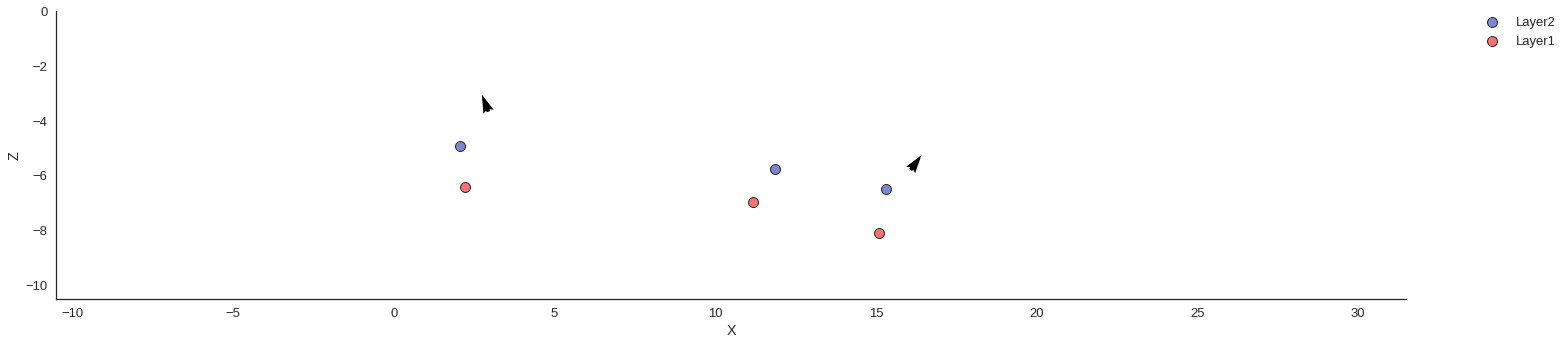

In [5]:
gp.set_series(geo_data, {'fault_serie1': 'fault1','younger_serie' : 'Unconformity', 'older_serie': ('Layer1', 'Layer2')},
              order_formations= ['fault1', 'Unconformity', 'Layer2', 'Layer1'], verbose=0)

geo_data.modify_interface(9, Z = -6.4)

geo_data = gp.select_series(geo_data, ['older_serie'])
gp.get_sequential_pile(geo_data)

gp.plot_data(geo_data)

In [6]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], dtype='float32', verbose=[])

lith, fault = gp.compute_model(interp_data)

ver_s, sim_s = gp.get_surfaces(interp_data,lith[1], None, original_scale=True)

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


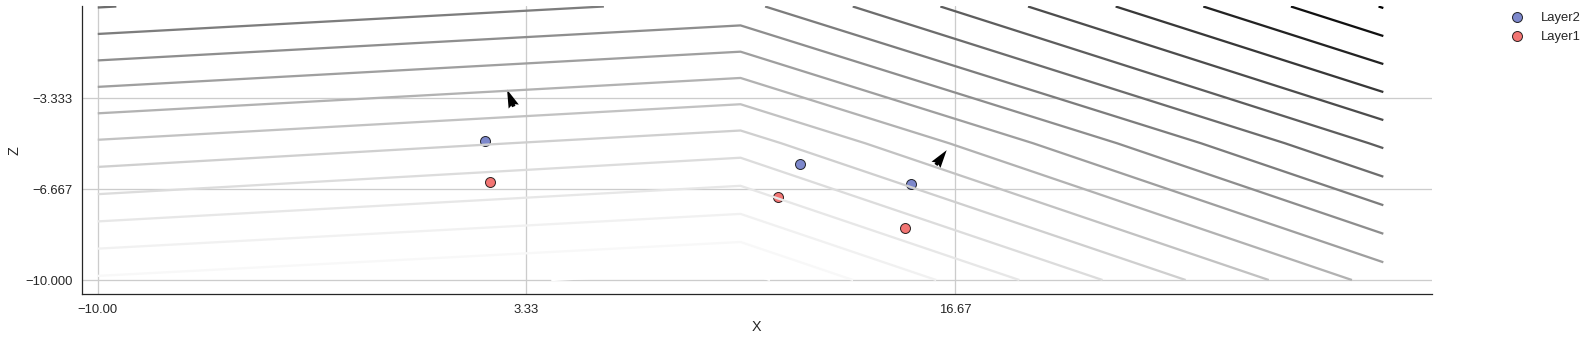

In [7]:
# Here we can see the marching cube error and why with so little resolution does not work
gp.plot_scalar_field(geo_data, lith[1], 2)
ax = plt.gca()
ax.set_xticks(np.linspace(-10, 30, res, endpoint=False))
ax.set_yticks(np.linspace(-10, 0, res, endpoint=False))
plt.grid()

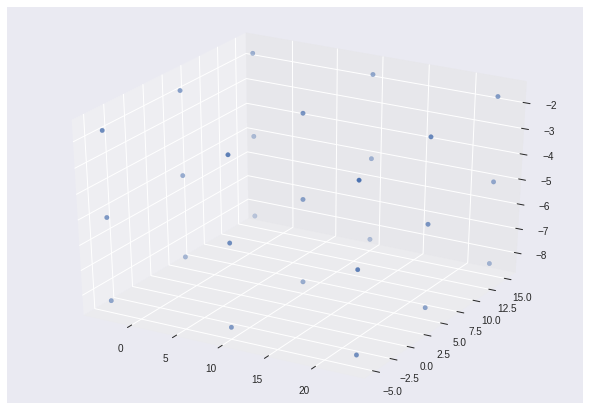

In [9]:
## Plotting geo_data.grid.vales --> one can see that it does not give the wanted centroids of the voxels. FIXED!

plt.style.use('seaborn')
plt.close('all')

fig = plt.figure()
ax = Axes3D(fig)
#ax.scatter3D(geo_data.grid.grid[:,0], geo_data.grid.grid[:,1], geo_data.grid.grid[:,2])
ax.scatter3D(*geo_data.grid.values.T)

In [10]:
def getBinLengthAndCenter(up, down, res):
    intervals  = np.arange(1, 2*res, 2)
    divide  = (up - down)/(2*res)
    centers = down + intervals*divide
    return divide, centers
    
# function to compute centroids of voxels in our domain
# returns coordinates of centroids and half the voxel length along each coordinate axis
def computeCentroids(xdown, xup, ydown, yup, zdown, zup, res):
    # Compute intervals
    dividex, possx = getBinLengthAndCenter(xup, xdown, res)
    dividey, possy = getBinLengthAndCenter(yup, ydown, res)
    dividez, possz = getBinLengthAndCenter(zup, zdown, res)
    
    # Get all centroids by combinations of x, y, z
    cposs = [possx, possy, possz]
    centroids = list(itertools.product(*cposs))
    
    return np.array(centroids), dividex, dividey, dividez

In [11]:
# calculate centroids of voxels in domain 
centroids, dividex, dividey, dividez = computeCentroids(xdown, xup, ydown, yup, zdown, zup, res)

(-10, 0)

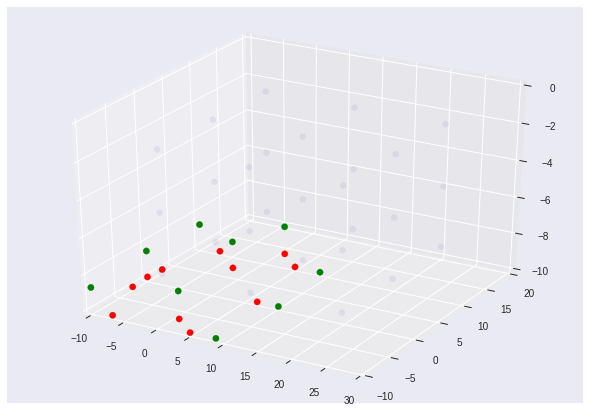

In [12]:
# Plot centroids of the voxels as well as the corner points of the simplices of the different layers 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter3D(*centroids.T, s=40, color='b', alpha=0.05)
ax.scatter3D(*geo_data.grid.values.T, color='y', alpha=0.05)  # Now they are the same!
ax.scatter3D(*ver_s[0].T,  s=40, color='g', alpha=1.0)
ax.scatter3D(*ver_s[1].T,  s=40, color='r', alpha=1.0)
ax.set_xlim(xdown, xup)
ax.set_ylim(ydown, yup)
ax.set_zlim(zdown, zup)

In [13]:
# But the formations still look quite bad
gp.plot_surfaces_3D(geo_data, ver_s, sim_s, alpha=1)

### Change the grid to see the effect in the marching cube

In [76]:
# However as we increase the resolution the model looks better and better! This I guess it is the marching cube error
new_grid = gp.GridClass()
res = 30

# calculate centroids of voxels in domain 
centroids, dividex, dividey, dividez = computeCentroids(xdown, xup, ydown, yup, zdown, zup, res)

# Create a new grid object with the new resolution
new_grid.create_regular_grid_3d([xdown,xup,ydown,yup,zdown,zup],[res, res, res])

# Setting the new grid to the geodata
gp.set_grid(geo_data, new_grid)

# Update the interp_data
interp_data.update_interpolator(geo_data)

# Recomputiong
lith, fault = gp.compute_model(interp_data)

ver_s, sim_s = gp.get_surfaces(interp_data,lith[1], None, original_scale=True)



In [77]:
# Plotting
gp.plot_surfaces_3D(geo_data, ver_s, sim_s, alpha=1)

### Computing the gray voxels

In [78]:
# Computing which voxels are cutted by which simpleces
# Functions
# radius corresponds to half the diagonal of the voxel
def computeVoxelRadius( xdown,  xup,  ydown, yup, zdown,  zup,  res):
    binSize = lambda up, down: (up - down)/res
    
    bin_size_x = binSize(xup, xdown)
    bin_size_y = binSize(yup, ydown)
    bin_size_z = binSize(zup, zdown)
    return np.sqrt(bin_size_x**2 + bin_size_y**2 + bin_size_z**2)/2

def dist(center, points):
    return np.sqrt( np.sum( (center - points)**2, axis=1) )

intersections = {'layer': [], 'voxel': [], 'simplex': []}


#### Previous code- 2 secs:

In [68]:
# Precompute the constant radius
radius = computeVoxelRadius(xdown, xup, ydown, yup, zdown, zup, res)

intersections = {'layer': [], 'voxel': [], 'simplex': []}

for clayer, (sim_l, ver_l) in enumerate(zip(sim_s, ver_s)): # all the layers
    for csim, sim_t in enumerate(sim_l):                    # all the triangles in layer
        ver_t = ver_l[sim_t]
        
        for ccentroid, centroid in enumerate(centroids):    # all the voxels
            inside = dist(centroid, ver_t) <= radius        # test if simplex/triangle is inside voxel
            
            if np.all(inside):
                intersections['layer'].append(clayer)
                intersections['voxel'].append(ccentroid)
                intersections['simplex'].append(csim)
                break

intersections = {k: np.array(v) for k, v in intersections.items()}

KeyboardInterrupt: 

#### Creating and compiling the theano function in C. 10 ms

In [79]:
# Theano function
import theano.tensor as T
import theano
    

x_1 = T.matrix()
x_2 = T.matrix()
radious = T.scalar()

    # T.maximum avoid negative numbers increasing stability
sqd = T.sqrt(T.maximum(
    (x_1**2).sum(1).reshape((x_1.shape[0], 1)) +
    (x_2**2).sum(1).reshape((1, x_2.shape[0])) -
    2 * x_1.dot(x_2.T), 0.000001
))

sqd_reshaped = sqd.reshape((-1, 3, sqd.shape[1]))

sqd_bool = T.lt(sqd_reshaped, radious)

check = T.prod(sqd_bool, axis=1)

indi = T.nonzero(check)

th_f = theano.function([x_1, x_2, radious], indi, allow_input_downcast=True)


In [80]:
# Running the loop with the theano function

# The number of triangles to choose at every iteration. If you run out of memory
# use a smaller number
size_chunk_max = 1000



# Computing the maximum radio. The error selecting multiple voxel comes
# because the voxels are not cubes I think
radious = computeVoxelRadius(xdown, xup, ydown, yup, zdown, zup, res)



# Looping the layers
for clayer, (sim_l, ver_l) in enumerate(zip(sim_s, ver_s)): # all the layers
    # Inint the slicing of triangles
    n_triangles_0 = 0
    
    # Selecting the size of the chunk of triangles
    if sim_l.shape[0]+1 < size_chunk_max:
        size_chunk = sim_l.shape[0]
    else:
        size_chunk = size_chunk_max 
    
    # Looping chunks of triangles
    for n_triangles_1 in np.linspace(size_chunk, sim_l.shape[0],( sim_l.shape[0]+1)/size_chunk, dtype=int):      
        
        # selecting chunk 
        ver_t = ver_l[sim_l][n_triangles_0:n_triangles_1]
        
        # Computing indices
        indices= th_f(ver_t.reshape(-1, 3), centroids, radious)
        
        # Storing results
        if n_triangles_0 is 0 and clayer is 0:
            layers = clayer*np.ones(indices[0].shape[0])
            voxels = indices[1]
            simpleces = indices[0]+n_triangles_0
        else:
            layers = np.hstack((layers, clayer*np.ones(indices[0].shape[0])))
            voxels = np.hstack((voxels, indices[1]))
            simpleces = np.hstack((simpleces,indices[0]+n_triangles_0))

        # Switching the slice interval
        n_triangles_0 = n_triangles_1

In [81]:
# Passing the results to same format as it was before
intersections = {'layer': [], 'voxel': [], 'simplex': []}


intersections['voxel'] = voxels.astype(int)
intersections['simplex'] = simpleces.astype(int)
intersections['layer'] = layers.astype(int)

Intersections is a dictionary with three arrays. In 'voxel' one can find the id of the cutted voxels. 'layer' contains the corresponding layer and 'simplex' the corresponding triangle.

In [82]:
# Code to compute volume ratio in cutted voxels
# First compute plane of triangle cutting the voxel, then with plane function evaluate which points of voxel are 
# above and below, then compute with ConvexHull the volume ratio
class Plane:
    def __init__(self, three_poins):
        u = three_poins[1] - three_poins[0]
        v = three_poins[2] - three_poins[0]
        self.normal =  np.cross(u, v)
        self.const  = -np.dot(self.normal, three_poins[2])
        
    
    def evaluatePlaneEqn(self, points):
        return np.array([self.normal.dot(p) + self.const for p in points])
        
    def classify(self, points):
        """
        Decide which point is on top and which is below the plane.
        """
        residuals = self.evaluatePlaneEqn(points)
        upper     = np.where(residuals > 0.0)
        lower     = np.where(residuals < 0.0)
        return upper, lower
    

def uniqueTriNodes(tris):
    """
    Returns an array with the unique nodes in a list of triangles.
    """
    return np.array(list(set([tuple(row) for row in np.vstack(tris)])))

def getRatiosQuadTris(quad, tris):
    plane = Plane(tris[0])
    upper, lower = plane.classify(quad)
    
    tri_points = uniqueTriNodes(tris)
    upper_hull = ConvexHull(np.vstack([quad[upper], tri_points]))
    lower_hull = ConvexHull(np.vstack([quad[lower], tri_points]))
    
    upper_volume = upper_hull.volume
    lower_volume = lower_hull.volume
    total_volume = upper_volume + lower_volume
    return upper_volume/total_volume, lower_volume/total_volume

In [83]:
# Calculate volume ratios of cutted voxels
uni_vox_points = np.array([[-1, -1, -1], 
                           [ 1, -1, -1], 
                           [ 1,  1, -1], 
                           [-1,  1, -1], 
                           [-1, -1,  1], 
                           [ 1, -1,  1], 
                           [ 1,  1,  1], 
                           [-1,  1,  1]])

def getTriangle(layer_idx, sims_idx):
    return [ver_s[layer_idx][sim_s[layer_idx][i]] for i in sims_idx]

def getQuad(centroid, dx, dy, dz):
    return centroid + uni_vox_points*[dx, dy, dz]

n_interfaces  = len(np.unique(intersections['layer']))
unique_voxels = np.unique(intersections['voxel'])

voxel_ratio = np.zeros((len(unique_voxels), n_interfaces + 1))
voxels = []

In [84]:
for i, vox in enumerate(unique_voxels):
    voxels.append(vox)
    
    # Gather data
    indices = intersections['voxel'] == vox
    cutting_sims   = intersections['simplex'][indices]
    cutting_layers = intersections['layer'][indices]

    # Reconstruct the voxel (gives corner points of voxel)
    quad = getQuad(centroids[vox], dividex, dividey, dividez)

    unique_cutting_layers = np.unique(cutting_layers)
    
    # I am sorry for the confusing naming of variables. In the following we consider two cases. The voxel is only
    # cutted by one layer and the voxel is cutted by two layers. But actually those layers are interfaces between 
    # layers. So in the first case one interface is dividing the voxel in two layers. Upper_ratio gives the volume 
    # ratio of the layer above the interface and lower_ratio gives the volume ratio of the layer below the interface. 
    # In the second case is a bit more complicated. Here the voxel is cutted by two interfaces into three layers.
    # First we compute for the first interface (upper interface) only the volume ratio of the layer above. Then we 
    # compute for the second interface (lower interface, called third layer here)  the volume ratio of the layer below.
    # Now we are only missing the volume ratio of the layer between the two interfaces --> mid layer. We easily computing
    # by substracting the two other ratios of one. The code can only deal so far with voxels cutted by maximum two 
    # layers (which is sufficient for our model problem). For voxels cutted by more layers it gives a value error.
    
    if len(unique_cutting_layers) == 1: # voxel is cutted by one layer
        cutting_layer = cutting_layers[0]
        tri = getTriangle(cutting_layer, cutting_sims)
        upper_ratio, lower_ratio = getRatiosQuadTris(quad, tri)

        voxel_ratio[i, cutting_layer]     = upper_ratio
        voxel_ratio[i, cutting_layer + 1] = lower_ratio
        
    elif len(unique_cutting_layers) == 2: # voxel is cutted by two layers
        unique_cutting_layers = np.sort(unique_cutting_layers)
        
        # 1st layer
        ## Gather data
        first_layer = unique_cutting_layers[0]
        first_sims  = cutting_sims[cutting_layers == first_layer]
        tri = getTriangle(first_layer, first_sims)

        ## Computation
        first_ratio, _ = getRatiosQuadTris(quad, tri)
        
        ## Store result
        voxel_ratio[i, first_layer] = first_ratio


        # 3nd layer
        ## Gather data
        third_layer = unique_cutting_layers[1]
        third_sims  = cutting_sims[cutting_layers == third_layer]
        tri = getTriangle(third_layer, third_sims)

        ## Computation
        _, third_ratio = getRatiosQuadTris(quad, tri)


        ## Store result
        voxel_ratio[i, third_layer + 1] = third_ratio


        # Mid layer
        mid_layer = third_layer
        voxel_ratio[i, mid_layer] = 1 - first_ratio - third_ratio
        
    else:
        raise ValueError('Cannot compute more than 2 interfaces/layers cutting a voxel')

QhullError: QH6214 qhull input error: not enough points(3) to construct initial simplex (need 4)

While executing:  | qhull i Qt
Options selected for Qhull 2015.2.r 2016/01/18:
  run-id 1577536899  incidence  Qtriangulate  _pre-merge  _zero-centrum


## Result

In [75]:
import pandas as pd

df = pd.DataFrame(voxel_ratio, index=voxels)
print(df.head())

           0         1         2
1   0.000000  0.763703  0.236297
6   0.002600  0.997400  0.000000
7   0.832239  0.167761  0.000000
41  0.000000  0.755328  0.244672
46  0.004101  0.995899  0.000000


In 'df' one has the needed results. For each cutted voxel (index on the left) one gets the volume ratio of the layer in the voxel. The numbering from the layers starts from the top. 

In [28]:
df.to_pickle("weights.pickle")

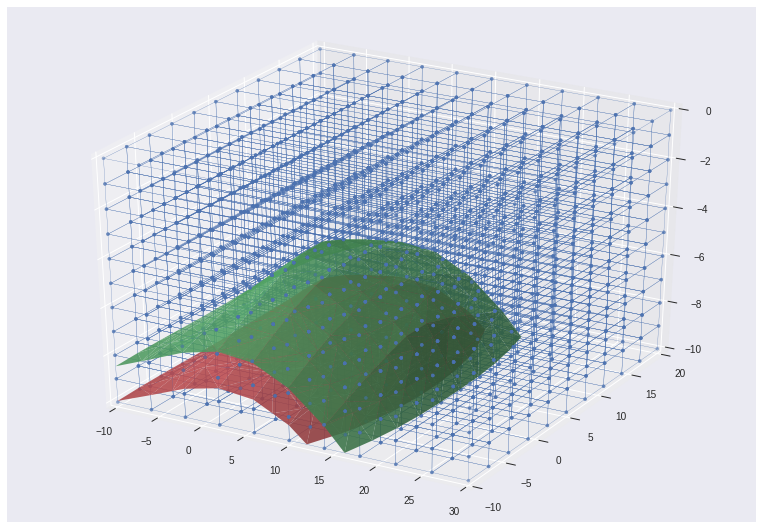

In [382]:
# Some plotting
%matplotlib inline
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

fig = plt.figure()
ax = Axes3D(fig)

edges = [[0, 1], [1, 2], [2, 3], [3, 0], [0, 4], [1, 5],
         [2, 6], [3, 7], [4, 5], [5, 6], [6, 7], [7, 4]]

def plotQuadEdges(quad, ax):
    for p, q in edges:
        ax.plot(*zip(quad[p], quad[q]), c='C0', lw=0.25)

def plotQuad(centroid, dx, dy, dz, ax):
    quad = getQuad(centroid, dx, dy, dz)
    faces = []
    
    # Vertices
    ax.scatter3D(*quad.T, s=10, color='C0', alpha=0.5)
    
    # Edges
    plotQuadEdges(quad, ax)

    
# Plot if the resolution is manageable

for centroid in centroids:
    plotQuad(centroid, dividex, dividey, dividez, ax)
if res < 11:
    for c, (sim_l, ver_l) in enumerate(zip(sim_s, ver_s)):
        ax.plot_trisurf(*ver_l.T, triangles=sim_l, color='C%d' % (c+1), alpha=0.88)

    ax.set_xlim(xdown, xup)
    ax.set_ylim(ydown, yup)
    ax.set_zlim(zdown, zup)